<a href="https://colab.research.google.com/github/offthetab/NN_homework/blob/main/MNIST_number_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install torch

In [ ]:
import torch as th
import numpy as np
import random
import matplotlib.pyplot as plt


#сделаем инициализацию random seed,
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [ ]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

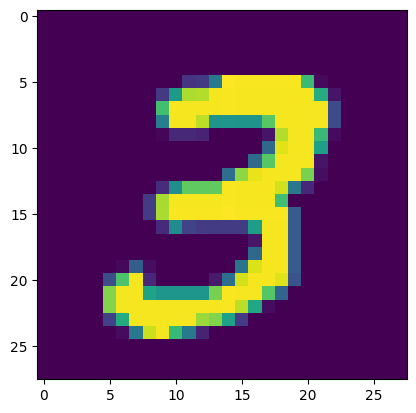

tensor(3)


In [ ]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [ ]:
#у нас трезмерный тензор, мы хотим двумерный тензор,
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)

print(y_test)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([7, 2, 1,  ..., 4, 5, 6])


In [ ]:
class MNISTnet(th.nn.Module):
  def __init__(self):
      super(MNISTnet, self).__init__()

      # 1 входной слой
      self.fc1 = th.nn.Linear(28 * 28, 20)
      self.act1 = th.nn.Sigmoid()

      # 2 скрытый слой
      self.fc2 = th.nn.Linear(20, 20)
      self.act2 = th.nn.LeakyReLU()

      # 3 выходной слой
      self.out = th.nn.Linear(20, 10) # числа от 0 до 9
      self.sm = th.nn.Softmax(dim=1) # вероятность принадлежности к калассу

  def forward(self, x):
      x = self.fc1(x)
      x = self.act1(x)

      x = self.fc2(x)
      x = self.act2(x)

      x = self.out(x)
      return x

  def predict(self, x):
      with th.no_grad():
        x = self.forward(x)
        x = x.reshape(1, -1)
        x = self.sm(x)
        return x

net = MNISTnet()

In [ ]:
''' есть ли видеокарта?'''
th.cuda.is_available()

False

In [ ]:
'''смотрим, занята ли карта какими либо вычислениями'''
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
""" теперь нужно переложить вычисления на видеокарту"""

device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)

In [ ]:
loss = th.nn.CrossEntropyLoss() # функция потерь
opt = th.optim.Adam(net.parameters(), lr=0.001) # #оптимизатор

In [ ]:
def start(batch_size, epochs):
  acc = []
  train_loss = []
  test_loss = []

  for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range (0,len(X_train), batch_size):

      opt.zero_grad()

      batch_indexes = order[start_index:start_index + batch_size]
      X_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]

      preds = net.forward(X_batch)
      loss_value = loss(preds, y_batch)
      loss_value.backward()

      opt.step()

    # accuracy на тестовых данных
    test_preds = net.forward(X_test)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    acc.append(float(accuracy))

    # train loss
    train_prediction = net.forward(X_train)
    train_loss.append(float(loss(train_prediction, y_train)))

    # test loss
    test_prediction = net.forward(X_test)
    test_loss.append(float(loss(test_prediction, y_test)))

  return acc, train_loss, test_loss

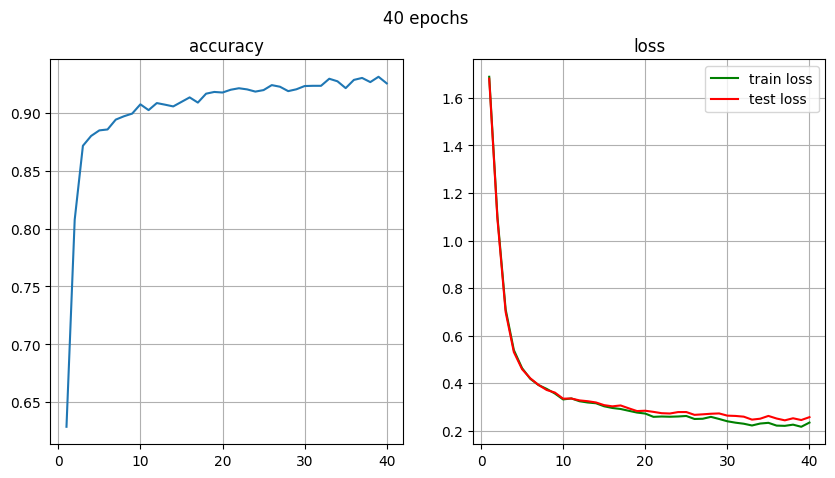

In [ ]:
accuracy, train_loss, test_loss = start(1_000, 40)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('40 epochs')

ax[0].plot(np.arange(1, len(accuracy)+1), accuracy)
ax[0].set_title("accuracy")
ax[0].grid()

epochs = np.arange(1, len(accuracy)+1)
ax[1].plot(epochs, train_loss, color='green', label='train loss')
ax[1].plot(epochs, test_loss, color='red', label='test loss')
ax[1].set_title("loss")
ax[1].legend()
ax[1].grid()

In [ ]:
rand = np.random.randint(len(X_test), size=24)

model_predictions = [th.argmax(net.predict(X_test[rand[i]])).item()  for i in range(len(rand))]
real_number = y_test[rand]

print(f"Берем 10 случайных тестовых данных для проверки работы модели:\nПредсказания модели: {model_predictions} \nРеальные отв: {real_number}")

Берем 10 случайных тестовых данных для проверки работы модели:
Предсказания модели: [5, 3, 0, 9, 5, 5, 2, 7, 7, 7, 0, 0, 2, 5, 6, 9, 3, 9, 3, 1, 6, 7, 1, 3] 
Реальные отв: tensor([5, 3, 0, 9, 5, 5, 2, 7, 7, 7, 0, 0, 2, 5, 6, 9, 3, 9, 3, 1, 6, 3, 1, 3])
